
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain wave characteristics for all synthetic TCs using RBF interpolation

inputs required:  
  * Synthetic simulation of historical TCs parameters (copulas obtained in *notebook 06*)
  * MaxDiss selection of synthetic simulated TCs (parameters obtained in *notebook 06*)
  * Simulated waves for the above selected TCs (**outside TeslaKit**)
  * Runup Nearshore at 3 locations (N, S, E) (**outside TeslaKit**)
  
in this notebook:
  * Selection of representative offshore Hs, Tp and Dir for each synthetic TC based on the max runup nearshore
  * Estimation of mu and tau for each synthetic TC
  * RBF's interpolation of wave conditions based on TCs parameters (from swan simulated TCs waves)

In [13]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import xarray as xr
import numpy as np

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation



## Database and Site parameters

In [14]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN_emulator')
           

In [15]:
# --------------------------------------
# load data and set parameters

# r2 TCs synthetic Nakajo (dataset) 
TCs_r2_sim_params = db.Load_TCs_r2_sim_params()
print(TCs_r2_sim_params)
print()

# r2 TCs MDA selection 
TCs_r2_MDA_params = db.Load_TCs_r2_mda_params()
print(TCs_r2_MDA_params)
print()

# Solved simulations OFFSHORE (not solved inside teslakit). 
# OFFSHORE TC waves (500 TCs are simulated with non stationary SWAN at 2 different time steps)
# To update Sea waves in the emulator  
TCs_sims_offsh_10 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs_offshore/MDA500/output_nonstat_pts_dt10.nc')
TCs_sims_offsh_20 = xr.open_dataset('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs_offshore/MDA500/output_nonstat_pts_dt20.nc')

TCs_sims_offsh_20 = TCs_sims_offsh_20.resample(time='10Min').interpolate('linear')
TCs_sims_offsh = xr.concat([TCs_sims_offsh_10,TCs_sims_offsh_20], dim="case")
#TCs_sims.to_netcdf('/Users/albacid/Projects/SERDP/inputs_Kwajalein/TCs/MDA500/output_nonstat_pts.nc')

TCs_sims_offsh = TCs_sims_offsh.drop({'DEP','TM02','DSPR','WIND','OUT','x_point', 'y_point','WATLEV'})
TCs_sims_offsh = TCs_sims_offsh.drop({'HSWELL'}) # tb se descarta porque solo simulamos TCs cerca del site??
TCs_sims_offsh = TCs_sims_offsh.rename({'case':'storm'})
TCs_sims_offsh = TCs_sims_offsh.squeeze()
print(TCs_sims_offsh)
print()


# Load hycreww runup NEARSHORE. To obtain mu and tau in the 3 areas (N, S, E) 
runup_N = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_N.nc')
runup_S = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_S.nc') 
runup_E = xr.open_dataset('/Users/albacid/Projects/TeslaKit_projects/sites/KWAJALEIN_emulator/HYCREWW/sim_TCs_runup_E.nc') 

runup_N = runup_N.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})
runup_S = runup_S.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})
runup_E = runup_E.drop({'level','hs_lo2','rslope','bslope','rwidth', 'cf','hs','tp','dir'})

runup_N = runup_N.rename({'runup':'runup_N'})
runup_S = runup_S.rename({'runup':'runup_S'})
runup_E = runup_E.rename({'runup':'runup_E'})

runup = xr.merge([runup_N, runup_S, runup_E])
print(runup)


<xarray.Dataset>
Dimensions:        (storm: 10159)
Coordinates:
  * storm          (storm) int64 296 299 611 612 ... 999833 999845 999877 999986
Data variables:
    pressure_min   (storm) float64 ...
    pressure_mean  (storm) float64 ...
    velocity_mean  (storm) float64 ...
    gamma          (storm) float64 ...
    delta          (storm) float64 ...
    category       (storm) int64 ...
    dmin_date      (storm) float64 ...
    last_date      (storm) float64 ...
    index_in       (storm) int64 ...
    index_out      (storm) int64 ...
Attributes:
    point_lon:  167.73
    point_lat:  8.72
    point_r:    4

<xarray.Dataset>
Dimensions:        (storm: 500)
Coordinates:
  * storm          (storm) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    pressure_mean  (storm) float64 ...
    pressure_min   (storm) float64 ...
    velocity_mean  (storm) float64 ...
    delta          (storm) float64 ...
    gamma          (storm) float64 ...
Attributes:
    source:   

In [16]:
# Compute MU, TAU (for N, S & E) and TWL from SWAN simulated NEARSHORE Waves (synthetic TCs)

p_mean = 1009.54 # mean pressure from historical records (SLP.nc) (from nb 07a_TCs_Hycreww_RunUp)

for s in TCs_sims_offsh.storm.values:
    
    tcs_storm = TCs_sims_offsh.sel(storm=s)
    
    # drop nans
    tcs_storm = tcs_storm.where(~np.isnan(tcs_storm.HS), drop=True)  
    
    
    # WORST runup from the 3 profiles    
    runup_storm = runup.sel(storm=s, time = slice(tcs_storm.time[0], tcs_storm.time[-1]))
    runup_max = np.nanmax([runup_storm.runup_N, runup_storm.runup_S, runup_storm.runup_E], axis=0)
    runup_max_id = np.nanargmax(runup_max)
    runup_max_t = runup_storm.isel(time=runup_max_id)
    
    # keep variables at WORST runup 
    tcs_storm_max = tcs_storm.sel(time=runup_max_t.time)  

    
    # Storm Surge from Inverse Barometer from pressure min (not a time series)
    tcs_storm_max['ss'] = TCs_r2_MDA_params.pressure_min.sel(storm=s) - p_mean 
    tcs_storm_max['ss'] = -1*tcs_storm_max['ss']  # (Inverse Barometer: mb to cm)
    tcs_storm_max['ss'] = tcs_storm_max['ss']/100.0 # (cm to m)
    

    # twl (de Laura matlab)
    tcs_storm_max['twl'] = 0.053*tcs_storm_max.HS**(0.5)*tcs_storm_max.RTP + tcs_storm_max.ss
        
    
    # Calculate TAU for each section
    dt = 1.0/len(tcs_storm.time)
    t_norm = np.linspace(dt, 1, num=len(tcs_storm.time))
    
    id_max = runup_storm.argmax()
    tcs_storm_max['tau_N'] = t_norm[id_max.runup_N.values]
    tcs_storm_max['tau_S'] = t_norm[id_max.runup_S.values]
    tcs_storm_max['tau_E'] = t_norm[id_max.runup_E.values]
    
    
    # calculate MU for each section
    mu_N = np.trapz(np.divide(runup_storm.runup_N.values, runup_storm.runup_N.max().values), t_norm) # area debajo de la curva
    mu_S = np.trapz(np.divide(runup_storm.runup_S.values, runup_storm.runup_S.max().values), t_norm) # area debajo de la curva
    mu_E = np.trapz(np.divide(runup_storm.runup_E.values, runup_storm.runup_E.max().values), t_norm) # area debajo de la curva

    tcs_storm_max['mu_N'] = np.nanmax([mu_N, 0]) # si el runup es 0, mu queda nan, así pongo 0 en ese caso
    tcs_storm_max['mu_S'] = np.nanmax([mu_S, 0])
    tcs_storm_max['mu_E'] = np.nanmax([mu_E, 0])
    
    # concat cases
    if s==0:
        TCs_sims = tcs_storm_max        
    else:    
        TCs_sims = xr.concat([TCs_sims, tcs_storm_max], dim='storm')
        

TCs_sims = TCs_sims.rename({'HS':'hs','RTP':'tp','DIR':'dir'})        
print(TCs_sims)


<xarray.Dataset>
Dimensions:  (storm: 500)
Coordinates:
    time     (storm) datetime64[ns] 2020-01-01T08:10:00 ... 2020-01-02T20:40:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    hs       (storm) float64 0.000461 1.027 3.638 1.563 ... 2.735 3.286 0.9176
    dir      (storm) float64 300.6 168.0 34.69 106.8 ... 360.0 97.46 102.4 178.1
    tp       (storm) float64 1.941 4.144 9.723 8.044 ... 6.655 7.317 10.69 6.655
    ss       (storm) float64 -0.0247 0.14 0.6198 0.1849 ... 0.163 0.5541 0.104
    twl      (storm) float64 -0.02249 0.3625 1.603 ... 0.8044 1.581 0.4419
    tau_N    (storm) float64 0.1701 0.482 0.487 0.2735 ... 0.557 0.5773 0.4786
    tau_S    (storm) float64 0.5714 0.5396 0.6429 0.6239 ... 0.529 0.499 0.5479
    tau_E    (storm) float64 0.003401 0.8273 0.6429 ... 0.5153 0.4795 0.3971
    mu_N     (storm) float64 0.4469 0.3174 0.6991 ... 0.4573 0.6991 0.5737
    mu_S     (storm) float64 0.9519 0.6649 0.6912 0.533 ... 0.68

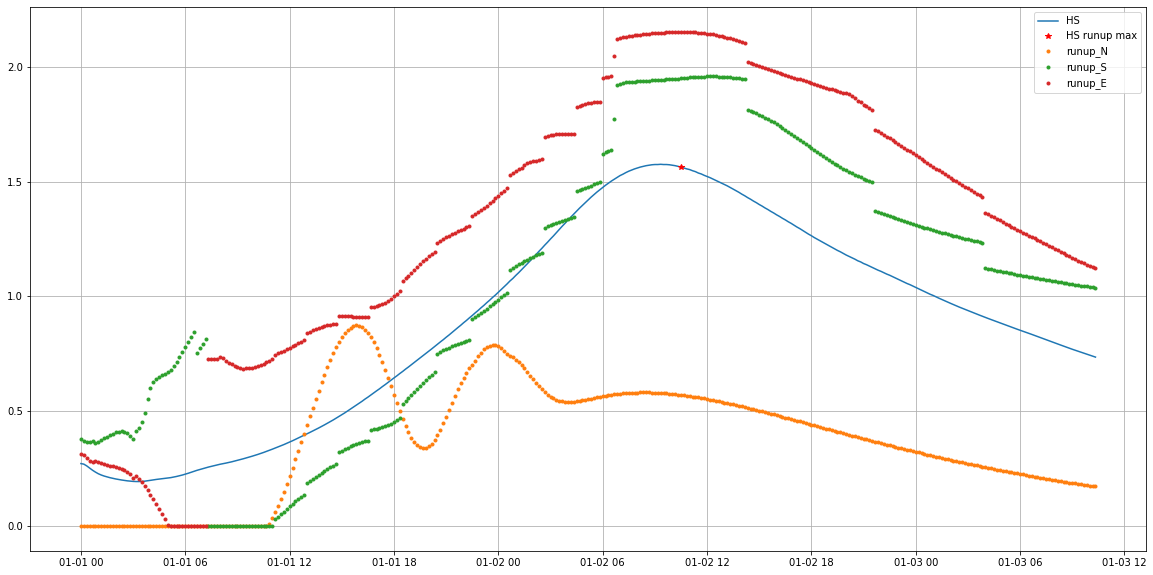

In [17]:

import matplotlib.pyplot as plt
from datetime import datetime

plt.figure(figsize=(20,10))
plt.plot(TCs_sims_offsh.time, TCs_sims_offsh.HS.sel(storm=5), label='HS')             
plt.plot(TCs_sims.time.sel(storm=5), TCs_sims.hs.sel(storm=5), '*r', label='HS runup max')           


plt.plot(runup.time, runup.runup_N.sel(storm=5), '.', label='runup_N')
plt.plot(runup.time, runup.runup_S.sel(storm=5), '.', label='runup_S')
plt.plot(runup.time, runup.runup_E.sel(storm=5), '.', label='runup_E')      
plt.legend()
plt.grid()


## Simulated TCs -  Radial Basis Function

In [6]:
# --------------------------------------
# prepare dataset and subset

#  RBFs training subset (TCs numerically solved)
subset = np.column_stack(
    (TCs_r2_MDA_params['pressure_min'], TCs_r2_MDA_params['velocity_mean'], 
     TCs_r2_MDA_params['gamma'], TCs_r2_MDA_params['delta'])
)

#  RBFs dataset to interpolate 
dataset = np.column_stack(
    (TCs_r2_sim_params['pressure_min'], TCs_r2_sim_params['velocity_mean'], 
     TCs_r2_sim_params['gamma'], TCs_r2_sim_params['delta'])
)


In [7]:
# --------------------------------------
# Extract waves data from TCs simulations (this is the RBFs training target)

print(TCs_sims)
print()


# Normalize data
d_maxis = {}
d_minis = {}
tcp = TCs_sims.copy()
for k in ['hs', 'tp', 'ss', 'twl']:
    v = tcp[k].values[:]
    mx = np.max(v)
    mn = np.min(v)
    tcp[k] =(('storm',), (v-mn)/(mx-mn))
    
    # store maxs and mins for denormalization
    d_maxis[k] = mx
    d_minis[k] = mn

tcp['dir'] = tcp['dir'] * np.pi/180
    
print(tcp)
print()


# Build RBF target numpy array
target = np.column_stack(
    (tcp['hs'], tcp['tp'], tcp['ss'], tcp['twl'], tcp['dir'], tcp['mu_N'], tcp['mu_S'], tcp['mu_E'], tcp['tau_N'], tcp['tau_S'], tcp['tau_E'])
)


<xarray.Dataset>
Dimensions:  (storm: 500)
Coordinates:
    time     (storm) datetime64[ns] 2020-01-01T08:10:00 ... 2020-01-02T20:40:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    hs       (storm) float64 0.000461 1.027 3.638 1.563 ... 2.735 3.286 0.9176
    dir      (storm) float64 300.6 168.0 34.69 106.8 ... 360.0 97.46 102.4 178.1
    tp       (storm) float64 1.941 4.144 9.723 8.044 ... 6.655 7.317 10.69 6.655
    ss       (storm) float64 -0.0247 0.14 0.6198 0.1849 ... 0.163 0.5541 0.104
    twl      (storm) float64 -0.02249 0.3625 1.603 ... 0.8044 1.581 0.4419
    tau_N    (storm) float64 0.1701 0.482 0.487 0.2735 ... 0.557 0.5773 0.4786
    tau_S    (storm) float64 0.5714 0.5396 0.6429 0.6239 ... 0.529 0.499 0.5479
    tau_E    (storm) float64 0.003401 0.8273 0.6429 ... 0.5153 0.4795 0.3971
    mu_N     (storm) float64 0.4469 0.3174 0.6991 ... 0.4573 0.6991 0.5737
    mu_S     (storm) float64 0.9519 0.6649 0.6912 0.533 ... 0.68

In [8]:
# --------------------------------------
# RBF Interpolation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5,6,7,8,9,10]  # scalar (Hs, Tp, SS, TWL, MU_N, MU_S, MU_E, TAU_N, TAU_S, TAU_E)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Reconstruction(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target,
    dataset)


ix_scalar: 0,  optimization: 38.94 | interpolation: 1.27
ix_scalar: 1,  optimization: 43.56 | interpolation: 1.09
ix_scalar: 2,  optimization: 42.83 | interpolation: 0.99
ix_scalar: 3,  optimization: 43.37 | interpolation: 0.77
ix_scalar: 5,  optimization: 36.62 | interpolation: 0.61
ix_scalar: 6,  optimization: 44.74 | interpolation: 0.72
ix_scalar: 7,  optimization: 44.32 | interpolation: 1.83
ix_scalar: 8,  optimization: 51.76 | interpolation: 0.63
ix_scalar: 9,  optimization: 37.97 | interpolation: 0.85
ix_scalar: 10,  optimization: 36.89 | interpolation: 0.61
ix_directional: 4,  optimization: 67.83 | interpolation: 1.15


In [9]:
# --------------------------------------
# Reconstructed TCs

# denormalize RBF output
TCs_RBF_out = xr.Dataset(
    {
        'hs':(('storm',), output[:,0] * (d_maxis['hs']-d_minis['hs']) + d_minis['hs'] ),
        'tp':(('storm',), output[:,1] * (d_maxis['tp']-d_minis['tp']) + d_minis['tp'] ),
        'ss':(('storm',), output[:,2] * (d_maxis['ss']-d_minis['ss']) + d_minis['ss'] ),
        'twl':(('storm',), output[:,3] * (d_maxis['twl']-d_minis['twl']) + d_minis['twl'] ),
        'dir':(('storm',), output[:,4] * 180 / np.pi),
        'mu_N':(('storm',), output[:,5]),
        'mu_S':(('storm',), output[:,6]),
        'mu_E':(('storm',), output[:,7]),
        'tau_N':(('storm',), output[:,8]),
        'tau_S':(('storm',), output[:,9]),
        'tau_E':(('storm',), output[:,10]),
    },
    coords = {'storm': np.arange(output.shape[0])}
)
print(TCs_RBF_out)


<xarray.Dataset>
Dimensions:  (storm: 10159)
Coordinates:
  * storm    (storm) int64 0 1 2 3 4 5 6 ... 10153 10154 10155 10156 10157 10158
Data variables:
    hs       (storm) float64 2.121 2.091 1.995 4.131 ... 2.568 1.772 1.916 1.077
    tp       (storm) float64 7.677 7.498 8.444 8.443 ... 8.467 6.992 7.66 5.095
    ss       (storm) float64 0.2899 0.293 0.3537 0.4167 ... 0.2511 0.2716 0.2068
    twl      (storm) float64 0.9075 0.9109 0.9955 1.408 ... 0.7775 0.8599 0.5412
    dir      (storm) float64 165.6 168.6 160.6 130.1 ... 153.1 181.0 207.1 199.4
    mu_N     (storm) float64 0.4878 0.4725 0.5668 0.4444 ... 0.458 0.489 0.4263
    mu_S     (storm) float64 0.6248 0.6264 0.6643 0.6041 ... 0.568 0.6288 0.6293
    mu_E     (storm) float64 0.5049 0.4777 0.5686 ... 0.4328 0.4964 0.3403
    tau_N    (storm) float64 0.4408 0.4421 0.4883 ... 0.4134 0.4205 0.3468
    tau_S    (storm) float64 0.5242 0.5539 0.5949 0.5574 ... 0.5793 0.4989 0.541
    tau_E    (storm) float64 0.5264 0.5139 0.6794

In [12]:
# store data as xarray.Dataset
TCs_RBF_out_N = TCs_RBF_out[['hs','tp','dir','ss','twl','mu_N','tau_N']]
TCs_RBF_out_S = TCs_RBF_out[['hs','tp','dir','ss','twl','mu_S','tau_S']]
TCs_RBF_out_E = TCs_RBF_out[['hs','tp','dir','ss','twl','mu_E','tau_E']]
TCs_RBF_out_N = TCs_RBF_out_N.rename({'mu_N':'mu', 'tau_N':'tau'})
TCs_RBF_out_S = TCs_RBF_out_S.rename({'mu_S':'mu', 'tau_S':'tau'})
TCs_RBF_out_E = TCs_RBF_out_E.rename({'mu_E':'mu', 'tau_E':'tau'})

TCs_RBF_out_N.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_N.nc'))
TCs_RBF_out_S.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_S.nc'))
TCs_RBF_out_E.to_netcdf(op.join(p_data, 'sites/KWAJALEIN_emulator/TCs/TCs_sim_r2_RBF_output_E.nc'))


In [10]:
# --------------------------------------
# RBF Validation

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]        # scalar (pmean,  vmean)
ix_directional_subset = [2,3]   # directional (delta, gamma)

# target - scalar / directional indexes
ix_scalar_target = [0,1,2,3,5,6,7,8,9,10]  # scalar (Hs, Tp, SS, TWL, MU_N, MU_S, MU_E, TAU_N, TAU_S, TAU_E)
ix_directional_target = [4]     # directional (Dir)

output = RBF_Validation(
    subset, ix_scalar_subset, ix_directional_subset,
    target, ix_scalar_target, ix_directional_target)


RBFs Kfold Validation: 1/3
ix_scalar: 0,  optimization: 14.03 | interpolation: 0.01
ix_scalar: 1,  optimization: 14.76 | interpolation: 0.01
ix_scalar: 2,  optimization: 14.74 | interpolation: 0.01
ix_scalar: 3,  optimization: 14.14 | interpolation: 0.01
ix_scalar: 5,  optimization: 14.23 | interpolation: 0.01
ix_scalar: 6,  optimization: 14.87 | interpolation: 0.01
ix_scalar: 7,  optimization: 14.82 | interpolation: 0.01
ix_scalar: 8,  optimization: 14.19 | interpolation: 0.01
ix_scalar: 9,  optimization: 13.85 | interpolation: 0.01
ix_scalar: 10,  optimization: 14.02 | interpolation: 0.01
ix_directional: 4,  optimization: 27.55 | interpolation: 0.02
mean squared error : 0.3626561120210457

RBFs Kfold Validation: 2/3
ix_scalar: 0,  optimization: 14.05 | interpolation: 0.01
ix_scalar: 1,  optimization: 13.89 | interpolation: 0.01
ix_scalar: 2,  optimization: 14.28 | interpolation: 0.01
ix_scalar: 3,  optimization: 13.89 | interpolation: 0.01
ix_scalar: 5,  optimization: 13.44 | interpo

<xarray.Dataset>
Dimensions:  (storm: 500)
Coordinates:
    time     (storm) datetime64[ns] 2020-01-01T08:10:00 ... 2020-01-02T20:40:00
  * storm    (storm) int64 0 1 4 5 7 10 11 13 ... 484 486 490 491 497 498 499
Data variables:
    hs       (storm) float64 0.000461 1.027 3.638 1.563 ... 2.735 3.286 0.9176
    dir      (storm) float64 300.6 168.0 34.69 106.8 ... 360.0 97.46 102.4 178.1
    tp       (storm) float64 1.941 4.144 9.723 8.044 ... 6.655 7.317 10.69 6.655
    ss       (storm) float64 -0.0247 0.14 0.6198 0.1849 ... 0.163 0.5541 0.104
    twl      (storm) float64 -0.02249 0.3625 1.603 ... 0.8044 1.581 0.4419
    tau_N    (storm) float64 0.1701 0.482 0.487 0.2735 ... 0.557 0.5773 0.4786
    tau_S    (storm) float64 0.5714 0.5396 0.6429 0.6239 ... 0.529 0.499 0.5479
    tau_E    (storm) float64 0.003401 0.8273 0.6429 ... 0.5153 0.4795 0.3971
    mu_N     (storm) float64 0.4469 0.3174 0.6991 ... 0.4573 0.6991 0.5737
    mu_S     (storm) float64 0.9519 0.6649 0.6912 0.533 ... 0.68

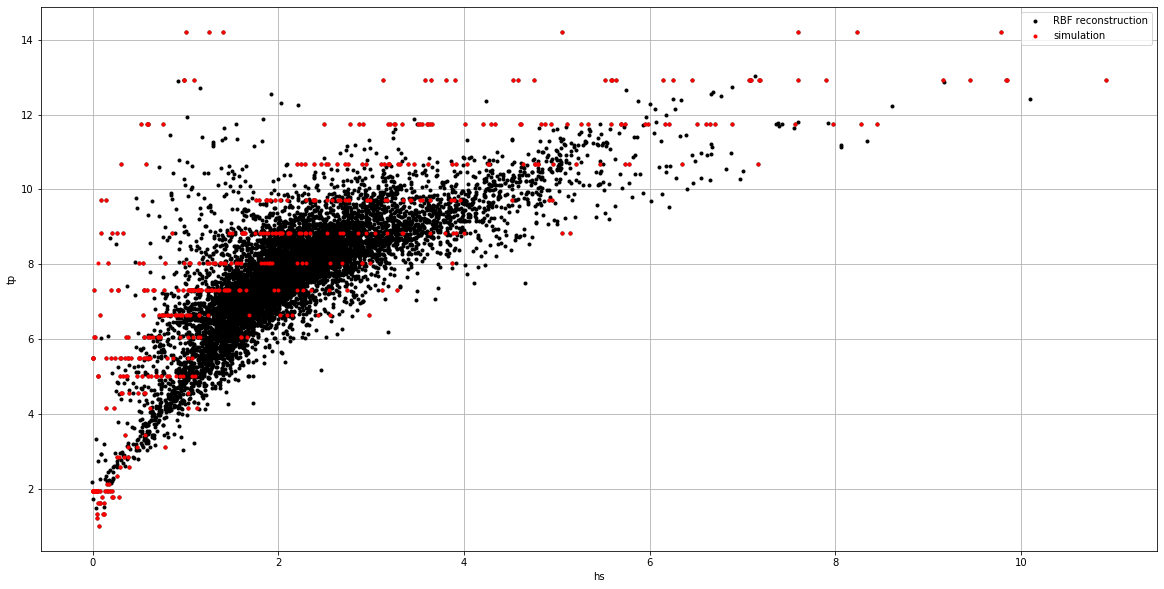

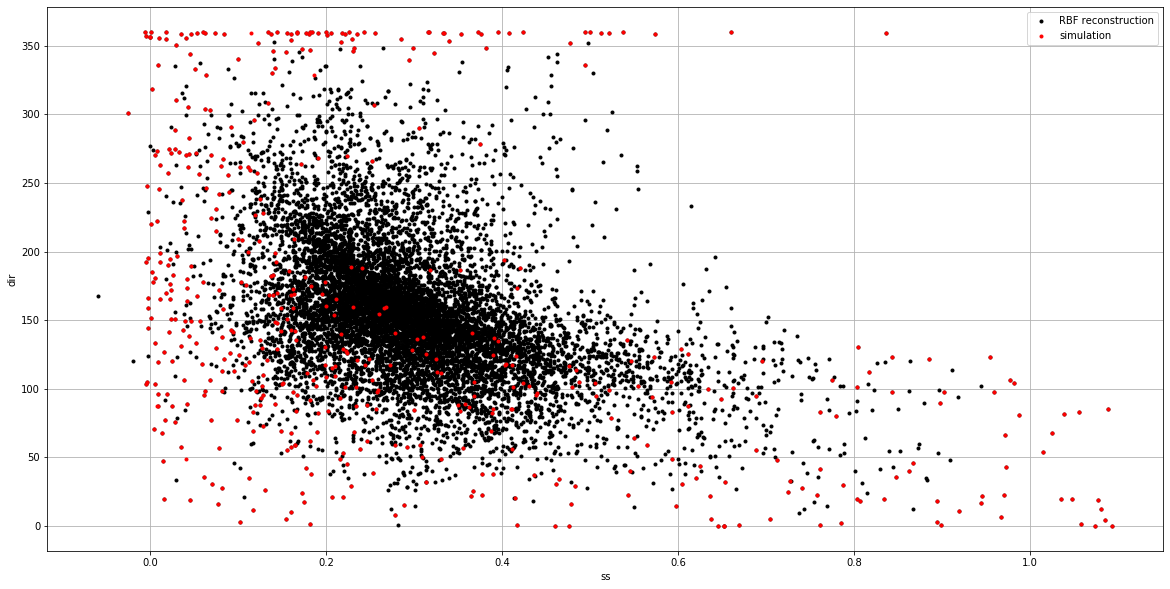

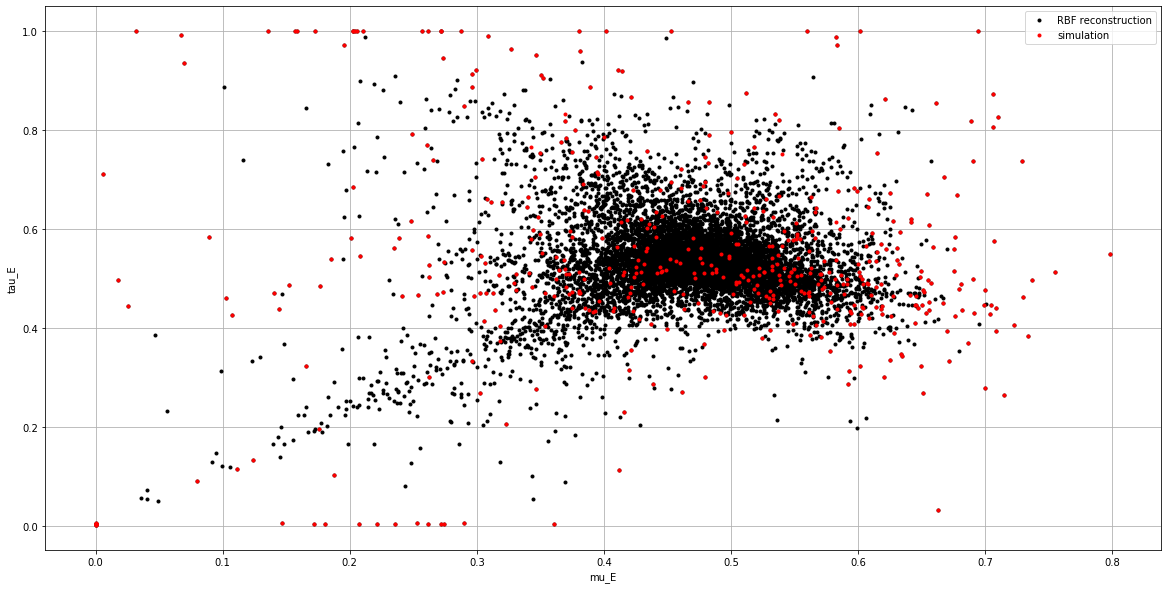

In [19]:
# "valida"

TCs_RBF_out = db.Load_TCs_sim_r2_rbf_output()

print(TCs_sims)
print()
print(TCs_RBF_out)

import matplotlib.pyplot as plt

var1 = 'hs'
var2 = 'tp'

plt.figure(figsize=(20,10))
plt.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.k', label='RBF reconstruction')
plt.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.r', label='simulation')
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend()
plt.grid()


var1 = 'ss' #'hs'
var2 = 'dir' #'tp'

plt.figure(figsize=(20,10))
plt.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.k', label='RBF reconstruction')
plt.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.r', label='simulation')
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend()
plt.grid()


var1 = 'mu_E' #'hs'
var2 = 'tau_E' #'tp'

plt.figure(figsize=(20,10))
plt.plot(TCs_RBF_out[var1].values[:], TCs_RBF_out[var2].values[:], '.k', label='RBF reconstruction')
plt.plot(TCs_sims[var1].values[:], TCs_sims[var2].values[:], '.r', label='simulation')
plt.xlabel(var1)
plt.ylabel(var2)
plt.legend()
plt.grid()